# TO DO 
pos_init = {xo:, sigma:  ......whitenoise:....}

pos_init.update({whitenoise: 100X so groß wie vorher})
=> new domain

gmfunc = partial(GM(xo, sigma))

vmap(gmfunc, 100x so großen whitespace über die richtige achse)

### New todo
find out why self.new_domain = None?
make jft.Model work and take a vector 

add to MF Model

make the same for GM models

In [1]:
import nifty8 as ift
import nifty8.re as jft
from jax import random
import jax.numpy as jnp
import numpy as np
import jax

In [2]:
from nifty8.re.tree_math import ShapeWithDtype

In [3]:
seed = 42
key = random.PRNGKey(seed)
e_dims = (10)
s_dims = (128, 128)

In [6]:
cf_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
cf_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
cfm = jft.CorrelatedFieldMaker("cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
correlated_field = cfm.finalize()

In [10]:
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"}
dev_cfm = jft.CorrelatedFieldMaker("cf")
dev_cfm.set_amplitude_total_offset(**cf_zm)
dev_cfm.add_fluctuations(
    e_dims,
    distances=1. / e_dims,
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_correlated_field = dev_cfm.finalize()

In [117]:
class NCopiesCorrField(jft.Model):
    def __init__(self, cf):
        self.cf = cf
        self.new_domain = None
        
    def _partly_apply_cf(self, pos_init):
        def partly(xi, xi_key):
            pos_init.tree.pop(xi_key)
            pos_init.tree.update({xi_key: xi})
            return self.cf(pos_init)
        return partly
        
    def _extend_xi_domain(self):
        dict = self.cf.domain.copy()
        new_domain = dict.update({"cfxi": ShapeWithDtype(shape=(10, 200))})
        self.new_domain = new_domain
        print("new domain juhuuuu")

    def partial_init_ncopies_model(self, key, subkey, pos_init=None):
        self._extend_xi_domain()
        key, subkey = random.split(key)
        if pos_init is not None:
            pos_init = jft.Vector(jft.random_like(subkey, self.cf.domain))
        func = self._partly_apply_cf(pos_init)
        ncopies_model_func = jax.vmap(func, in_axes=(1, None), out_axes=1)
        return jft.Model(ncopies_model_func, domain=self.new_domain)


In [118]:
n_copies_model = NCopiesCorrField(dev_correlated_field)

In [119]:
print(n_copies_model.cf.domain.keys())

dict_keys(['cfzeromode', 'cfax1fluctuations', 'cfax1loglogavgslope', 'cfax1spectrum', 'cfax1flexibility', 'cfax1asperity', 'cfxi'])


In [120]:
key, subkey = random.split(key)
n_copies_corr_field = n_copies_model.partial_init_ncopies_model(key,
                                                               subkey)

new domain juhuuuu


ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (1, None) for value tree PyTreeDef((None,)).

In [121]:
print(n_copies_model.new_domain)

None


In [122]:
pos_init = jft.Vector(jft.random_like(subkey, n_copies_model.new_domain))

In [10]:
alpha_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
alpha_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
alpha = jft.CorrelatedFieldMaker("alpha")
alpha.set_amplitude_total_offset(**alpha_zm)
alpha.add_fluctuations(
    dims,
    distances=1. / dims[0],
    **alpha_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
alpha_field = alpha.finalize()

In [11]:
freqs = jnp.arange(-2,10)
#freqs = jnp.array([1,3,4,7,12,17,19.3])

In [14]:
dims_freq = freqs.shape
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
dev = jft.CorrelatedFieldMaker("dev")
dev.set_amplitude_total_offset(**dev_zm)
dev.add_fluctuations(
    dims_freq,
    distances=1. / dims[0],
    **dev_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_field = dev.finalize()

In [15]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, dev_field.domain))
freq_dev = dev_field(pos_init)


In [52]:
dev = jft.WienerProcess((0, 1), (1, 3), 2, name="margret",N_steps= 10)

In [54]:
dev.domain

{'margret': ShapeWithDtype(shape=(10,), dtype=<class 'jax.numpy.float64'>),
 'margret_x0': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 'margret_sigma': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)}

key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, dev.domain))
dev(pos_init).shape

In [16]:
def mf_model(freqs, alph, spatial, dev):
    print(type(alph))
    if isinstance(alph, jft.Model):
        plaw = lambda x: jnp.outer(freqs, alph(x)).reshape(freqs.shape + alph.target.shape)
        res = lambda x: plaw(x) + spatial(x)
        domain = alph.domain | spatial.domain
        res = jft.Model(res, domain=domain)
    elif isinstance(alph, float):
        res = jnp.outer(freqs, alph).reshape(freqs.shape)
    return res

In [246]:
new_model = mf_model(freqs, alpha_field, correlated_field, dev_field)
#scalar_model = outer_product(freqs, 5.)

TypeError: mf_model() missing 1 required positional argument: 'dev'

In [226]:
scalar_model.shape

(8,)

In [227]:
jft.Gaussian

nifty8.re.likelihood_impl.Gaussian

In [228]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, new_model.domain))

In [229]:
field = new_model(pos_init)

In [230]:
import matplotlib.pyplot as plt

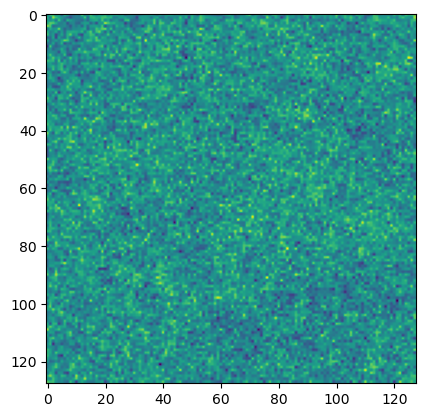

In [231]:
blub = alpha_field(pos_init)
plt.imshow(blub)

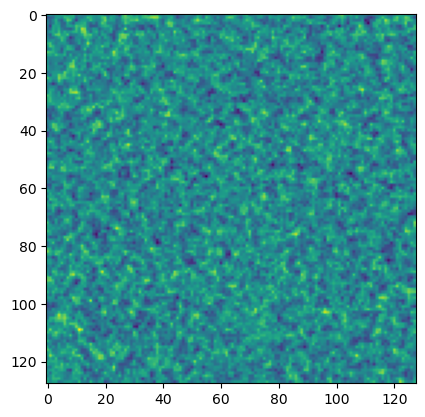

In [232]:
peng = correlated_field(pos_init)
plt.imshow(peng)

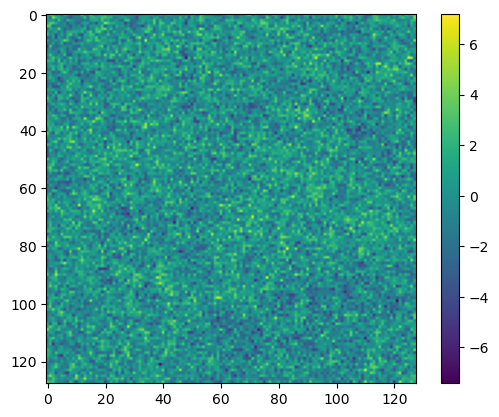

In [233]:
plt.imshow(field[6])
plt.colorbar()

In [234]:
peng[0,0] # spatial
blub[0,0] # alpha

Array(-0.06237071, dtype=float64)

In [236]:
xs = np.linspace(-2,6)
fxs = blub[0,0]*xs + peng[0,0]

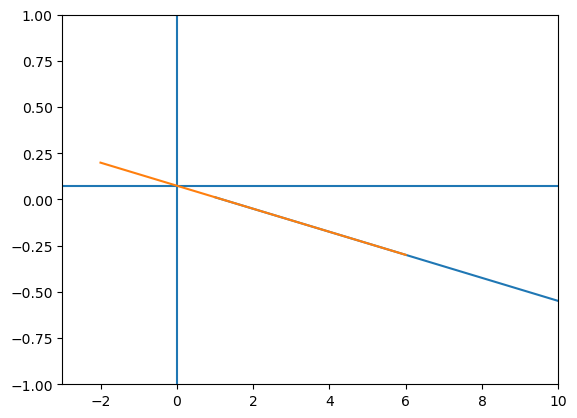

In [237]:
plt.plot(freqs, field[:,0,0])
plt.xlim(-3,10)
plt.ylim(-1,1)
plt.axvline(0,-1,1)
plt.axhline(peng[0,0], -1, 1)
plt.plot(xs, fxs)

In [35]:
correlated_field(pos_init).shape

(128, 128)

In [ ]:
class MFSky(jft.Model()):
    def __init__(spatial, alphas, deviations=None):
        self._spatial = spatial
        self._alphas = alphas

    def _model(self):
        res = jnp.outer()
        return res

In [44]:
import nifty8 as ift

# How it was on nifty

In [48]:
sp1 = ift.RGSpace([10])
cfmaker = ift.CorrelatedFieldMaker('', total_N=100)
cfmaker.add_fluctuations(sp1, (0.1, 1e-2), (2, .2), (.01, .5), (-4, 2.),
                             'amp1')
cfmaker.set_amplitude_total_offset(0., (1e-2, 1e-6))
correlated_field = cfmaker.finalize()

Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset amplitude: 1.00E-02 ± 1.02E-06
Offset ampli